In [202]:

import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

datos = pd.read_csv("../data/raw/dataset.csv")




In [203]:
def cross_validation_regression(conjunto, atributos, concepto, k=5, random=False, agregar_unos=False, undersample=False, oversample=False):
    if undersample:
        cantidad_menor_concepto = conjunto[concepto].value_counts().min()
        conjunto = pd.concat([conjunto[conjunto[concepto] == valor].sample(n=cantidad_menor_concepto, random_state=42) for valor in conjunto[concepto].unique()])

    if oversample:
        cantidad_mayor_concepto = conjunto[concepto].value_counts().max()
        conjunto = pd.concat([conjunto[conjunto[concepto] == valor].sample(n=cantidad_mayor_concepto, replace=True, random_state=42) for valor in conjunto[concepto].unique()])

    if random:
        conjunto = conjunto.sample(frac=1, random_state=11).reset_index(drop=True)

    x = conjunto[atributos]
    if agregar_unos:
        x.insert(0, "Unos", 1)

    y = conjunto[concepto]

    resultados = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        resultados.append((x_train, y_train, x_test, y_test))

    return resultados

def train_test_split_custom(conjunto, atributos, concepto, test_size=0.2, random_state=42):
    x = conjunto[atributos]
    y = conjunto[concepto]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    return x_train, y_train, x_test, y_test

In [204]:

def coding_categorical_columns(df):

    for column in df.columns:
        if len(df[column].unique()) <= 10 and df[column].dtype == 'object':
            unicos = df[column].unique()
            for i in range(len(unicos)):
                df[column] = df[column].replace({unicos[i]: i})
    return df

In [205]:
def categorical_and_numerical(df, features):
    categorical = []
    numerical = []

    for column in df[features].columns:
        if df[column].dtype == 'object':
            categorical.append(column)
        else:
            numerical.append(column)
    return categorical, numerical

In [206]:
features = datos.columns[:-1]
objetive_feature = datos.columns[-1]
#final_df = coding_categorical_columns(datos.copy())
datos_train, datos_val = train_test_split(datos, test_size=0.1, random_state=42)
categorical , numerical = categorical_and_numerical(datos, features)
print(categorical)
print(numerical)

['sex', 'smoker', 'region']
['age', 'bmi', 'children']


In [207]:
datos

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [125]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    median_absolute_error,
    mean_absolute_percentage_error
)

In [164]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [127]:
scoring_funcs = {
    "training_time" : 0,
    "prediction_time" : 0,
    "mean_absolute_error" : 0,
    "mean_squared_error" : 0,
    "r2_score" : 0,
    "explained_variance_score" : 0,
    "median_absolute_error" : 0,
    "mean_absolute_percentage_error" : 0
}

In [144]:
grid_boosting = {
    "boosting_model__n_estimators": [100, 200, 300, 500],
    "boosting_model__learning_rate": [0.001, 0.01, 0.1, 0.2],
    "boosting_model__max_depth": [1, 3, 5, 7],
    "boosting_model__min_samples_split": [2, 5, 10],
    "boosting_model__min_samples_leaf": [1, 2, 4],
    "boosting_model__random_state": [42]
}

In [129]:
grid_polinomial = {
    "degree": [2, 3, 4] # Bias always true, as we want to add intercept
}

In [145]:
grid_regresor_tree = {
    "boosting_model__criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "boosting_model__splitter": ["best", "random"],
    "boosting_model__max_depth": [None, 10, 20, 30],
    "boosting_model__min_samples_split": [2, 5, 10],
    "boosting_model__min_samples_leaf": [1, 2, 4],
    "boosting_model__random_state": [42]
}

In [131]:
def scoring_k_folds(dict, folds, model, k_folds):

    for x_train, y_train, x_test, y_test in folds:

        inicio = time.time()
        model.fit(x_train, y_train)
        fin = time.time()
        dict["training_time"] += (fin - inicio) / k_folds

        inicio = time.time()
        pred = model.predict(x_test)
        fin = time.time()
        dict["prediction_time"] += (fin - inicio) / k_folds

        dict["mean_absolute_error"] += mean_absolute_error(y_test, pred) / k_folds
        dict["mean_squared_error"] += mean_squared_error(y_test, pred) / k_folds
        dict["r2_score"] += r2_score(y_test, pred) / k_folds
        dict["explained_variance_score"] += explained_variance_score(y_test, pred) / k_folds
        dict["median_absolute_error"] += median_absolute_error(y_test, pred) / k_folds
        dict["mean_absolute_percentage_error"] += mean_absolute_percentage_error(y_test, pred) / k_folds
        
    return dict, model

def scoring_grid(dict, model, x_test, y_test):

    inicio = time.time()
    pred = model.predict(x_test)
    fin = time.time()
    dict["prediction_time"] += (fin - inicio)

    dict["mean_absolute_error"] += mean_absolute_error(y_test, pred) 
    dict["mean_squared_error"] += mean_squared_error(y_test, pred) 
    dict["r2_score"] += r2_score(y_test, pred) 
    dict["explained_variance_score"] += explained_variance_score(y_test, pred) 
    dict["median_absolute_error"] += median_absolute_error(y_test, pred) 
    dict["mean_absolute_percentage_error"] += mean_absolute_percentage_error(y_test, pred)
        
    return dict, model

In [174]:
def linear_regression_training(datos_train, features, objetive_feature, scoring_funcs, k_folds):
    linear_scoring = scoring_funcs.copy()

    categorical_features, numeric_features = categorical_and_numerical(datos_train, features)

    preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
    )

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    folds = cross_validation_regression(datos_train, features, objetive_feature, k=k_folds, random=42)

    linear_scoring, model = scoring_k_folds(linear_scoring, folds, pipeline, k_folds)

    return linear_scoring, pipeline

Funciona para hacerlo mas eficiente, ver que onda.

In [171]:
grid_polinomial_gridSearch = {
    "poly_features__degree": [2, 3, 4]  # Nota el nombre completo del paso
}

In [166]:




def polynomial_regression_grid_search(grid_split, grid, features, objetive_feature, k_folds, scoring_funcs):

    scoring_funcs_copy = scoring_funcs.copy()
    x_train = grid_split["x_train"]
    y_train = grid_split["y_train"]
    x_test = grid_split["x_test"]
    y_test = grid_split["y_test"]

    # Crear el pipeline con estandarización y características polinómicas
    categorical_features, numeric_features = categorical_and_numerical(x_train, features)

    preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
    )

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("scaler", StandardScaler()),
        ("poly_features", PolynomialFeatures(include_bias=True)),
        ("regressor", LinearRegression())
    ])

    grid = GridSearchCV(pipeline, grid, cv=k_folds, scoring='r2', n_jobs=-1)
    inicio = time.time()
    grid.fit(x_train[features], y_train)
    fin = time.time()
    scoring_funcs_copy["training_time"] = fin - inicio

    print(grid.best_params_)
    print(grid.best_score_)
    best_model = grid.best_estimator_
    best_dict, model = scoring_grid(scoring_funcs_copy, best_model, x_test, y_test)

    return best_model, best_dict

In [220]:
def boosting_regression_training_grid_search(grid_split, grid, features, objetive_feature, k_folds, scoring_funcs):

    scoring_funcs_copy = scoring_funcs.copy()
    x_train = grid_split["x_train"]
    y_train = grid_split["y_train"]
    x_test = grid_split["x_test"]
    y_test = grid_split["y_test"]

    categorical_features, numeric_features = categorical_and_numerical(x_train, features)

    preprocessor = ColumnTransformer(
    transformers=[
        #("num", StandardScaler(), numeric_features),
                ("num", "passthrough", numeric_features),

        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
    )

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("boosting_model", GradientBoostingRegressor())
    ])

    grid = GridSearchCV(pipeline, grid, cv= k_folds, scoring='r2', n_jobs=-1)
    inicio = time.time()
    grid.fit(x_train[features], y_train)
    fin = time.time()
    scoring_funcs_copy["training_time"] = fin - inicio

    print(grid.best_params_)
    print(grid.best_score_)
    best_model = grid.best_estimator_
    best_dict, model =  scoring_grid(scoring_funcs_copy, best_model, x_test, y_test)

    return best_model, best_dict

In [209]:
def decision_tree_regression_training_grid_search(grid_split, grid, features, objetive_feature, k_folds, scoring_funcs):

    scoring_funcs_copy = scoring_funcs.copy()
    x_train = grid_split["x_train"]
    y_train = grid_split["y_train"]
    x_test = grid_split["x_test"]
    y_test = grid_split["y_test"]

    categorical_features, numeric_features = categorical_and_numerical(x_train, features)

    preprocessor = ColumnTransformer(
    transformers=[
        #("num", StandardScaler(), numeric_features),
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
    )

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("boosting_model", DecisionTreeRegressor())
    ])
    grid = GridSearchCV(pipeline, grid, cv= k_folds, scoring='r2', n_jobs=-1)
    inicio = time.time()
    grid.fit(x_train[features], y_train)
    fin = time.time()
    scoring_funcs_copy["training_time"] = fin - inicio

    print(grid.best_params_)
    print(grid.best_score_)
    best_model = grid.best_estimator_
    best_dict, model =  scoring_grid(scoring_funcs_copy, best_model, x_test, y_test)

    return best_model, best_dict

In [252]:
resultados = {}
modelos = {}

x_train, y_train, x_test, y_test = train_test_split_custom(datos_train, features, objetive_feature, test_size=0.1, random_state=42)

grid_splits = {
    "x_train": x_train,
    "y_train": y_train,
    "x_test": x_test,
    "y_test": y_test
}

k_folds = 5

linear_scoring, linear_model = linear_regression_training(datos_train, features, objetive_feature, scoring_funcs, k_folds=5)
resultados["LinearRegression"] = linear_scoring
modelos["LinearRegression"] = linear_model

print("Linear Regression Grid Search Results ready")

poly_model, poly_scoring = polynomial_regression_grid_search(grid_splits, grid_polinomial_gridSearch, features, objetive_feature, k_folds, scoring_funcs)
resultados["PolynomialRegression"] = poly_scoring
modelos["PolynomialRegression"] = poly_model

print("Polynomial Regression Grid Search Results ready")

'''boosting_model, boosting_scoring = boosting_regression_training_grid_search(grid_splits, grid_boosting, features, objetive_feature, k_folds, scoring_funcs)
resultados["BoostingRegression"] = boosting_scoring
modelos["BoostingRegression"] = boosting_model

print("Boosting Regression Grid Search Results ready")'''

tree_model, tree_scoring = decision_tree_regression_training_grid_search(grid_splits, grid_regresor_tree, features, objetive_feature, k_folds, scoring_funcs)
resultados["TreeRegression"] = tree_scoring
modelos["TreeRegression"] = tree_model

print("Decision Tree Regression Grid Search Results ready")



Linear Regression Grid Search Results ready
{'poly_features__degree': 2}
0.8295325540915357
Polynomial Regression Grid Search Results ready
{'boosting_model__criterion': 'absolute_error', 'boosting_model__max_depth': None, 'boosting_model__min_samples_leaf': 2, 'boosting_model__min_samples_split': 10, 'boosting_model__random_state': 42, 'boosting_model__splitter': 'random'}
0.8280386379156723
Decision Tree Regression Grid Search Results ready


In [253]:
# Asegurarse de que todos los valores de 'resultados' sean diccionarios planos
resultados_limpios = {}
for k, v in resultados.items():
    if isinstance(v, dict):
        # Convertir los tiempos a segundos (si no lo están) y redondear a 4 decimales
        v["training_time"] = round(float(v.get("training_time", 0)), 4)
        v["prediction_time"] = round(float(v.get("prediction_time", 0)), 4)
        resultados_limpios[k] = v
    else:
        print(f"Advertencia: el resultado de {k} no es un diccionario y será omitido. Tipo: {type(v)}")

if not resultados_limpios:
    print("No hay resultados válidos para mostrar.")
else:
    df_resultados = pd.DataFrame(resultados_limpios).T
    print(df_resultados)

                      training_time  prediction_time  mean_absolute_error  \
LinearRegression             0.0157           0.0094          4227.845742   
PolynomialRegression         3.6872           0.0076          2766.928928   
TreeRegression              11.2390           0.0030          1498.776920   

                      mean_squared_error  r2_score  explained_variance_score  \
LinearRegression            3.780176e+07  0.742746                  0.743325   
PolynomialRegression        1.878467e+07  0.818895                  0.820980   
TreeRegression              1.475411e+07  0.857754                  0.861467   

                      median_absolute_error  mean_absolute_percentage_error  
LinearRegression                2500.356190                        0.421696  
PolynomialRegression            1848.401027                        0.304907  
TreeRegression                   404.610000                        0.097027  


In [254]:
df_resultados

,training_time,prediction_time,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_percentage_error
LinearRegression,0.0157,0.0094,4227.845742,3.780176e+07,0.742746,0.743325,2500.356190,0.421696
PolynomialRegression,3.6872,0.0076,2766.928928,1.878467e+07,0.818895,0.820980,1848.401027,0.304907
TreeRegression,11.2390,0.0030,1498.776920,1.475411e+07,0.857754,0.861467,404.610000,0.097027


In [239]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Supongamos que `df_resultados` contiene las métricas
# df_resultados ya está definido en tu código

def save_metrics_to_pdf(df_resultados, file_name="metrics_report.pdf"):
    # Crear un objeto PdfPages
    with PdfPages(file_name) as pdf:
        # Crear una figura
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis('tight')
        ax.axis('off')

        # Crear una tabla con los datos del DataFrame
        table = plt.table(cellText=df_resultados.values,
                          colLabels=df_resultados.columns,
                          rowLabels=df_resultados.index,
                          cellLoc='center',
                          loc='center')

        # Ajustar el tamaño de la tabla
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(df_resultados.columns))))

        # Agregar título
        plt.title("Model Metrics", fontsize=14, weight='bold')

        # Guardar la figura en el PDF
        pdf.savefig(fig, bbox_inches="tight")
        plt.close()

# Llamar a la función para guardar el DataFrame en un PDF
save_metrics_to_pdf(df_resultados, "metrics_report.pdf")

In [224]:
def validation_test(val_data, model, features, objetive_feature):
    x_val = val_data[features]
    y_val = val_data[objetive_feature]

    inicio = time.time()
    pred = model.predict(x_val)
    fin = time.time()
    prediction_time = fin - inicio

    mae = mean_absolute_error(y_val, pred)
    mse = mean_squared_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    evs = explained_variance_score(y_val, pred)
    medae = median_absolute_error(y_val, pred)
    mape = mean_absolute_percentage_error(y_val, pred)

    results = {
        "prediction_time": prediction_time,
        "mean_absolute_error": mae,
        "mean_squared_error": mse,
        "r2_score": r2,
        "explained_variance_score": evs,
        "median_absolute_error": medae,
        "mean_absolute_percentage_error": mape
    }

    return results

In [225]:
resultados = {}


for model in modelos:
    print(f"Validating model: {model}")
    resultados[model] = validation_test(datos_val, modelos[model], features, objetive_feature)
    print(f"Results for {model}: {resultados[model]}")

resultados_limpios = {}
for k, v in resultados.items():
    if isinstance(v, dict):
        # Convertir los tiempos a segundos (si no lo están) y redondear a 4 decimales
        v["prediction_time"] = round(float(v.get("prediction_time", 0)), 4)
        resultados_limpios[k] = v
    else:
        print(f"Advertencia: el resultado de {k} no es un diccionario y será omitido. Tipo: {type(v)}")

if not resultados_limpios:
    print("No hay resultados válidos para mostrar.")
else:
    df_resultados = pd.DataFrame(resultados_limpios).T
    df_resultados

    

Validating model: LinearRegression
Results for LinearRegression: {'prediction_time': 0.007130146026611328, 'mean_absolute_error': 4142.558205549579, 'mean_squared_error': 32139784.21268442, 'r2_score': 0.7670275482907529, 'explained_variance_score': 0.7702944669970923, 'median_absolute_error': 2566.8450595182417, 'mean_absolute_percentage_error': 0.4596303992863332}
Validating model: PolynomialRegression
Results for PolynomialRegression: {'prediction_time': 0.012048006057739258, 'mean_absolute_error': 2760.40992742727, 'mean_squared_error': 19789939.22121045, 'r2_score': 0.856548176271738, 'explained_variance_score': 0.8584441977213703, 'median_absolute_error': 1819.520284275466, 'mean_absolute_percentage_error': 0.31656194149999}
Validating model: BoostingRegression
Results for BoostingRegression: {'prediction_time': 0.006981611251831055, 'mean_absolute_error': 2370.8266008309624, 'mean_squared_error': 17201322.85788038, 'r2_score': 0.8753123439683483, 'explained_variance_score': 0.87

In [261]:
df_resultados

,training_time,prediction_time,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_percentage_error
LinearRegression,0.0157,0.0094,4227.845742,3.780176e+07,0.742746,0.743325,2500.356190,0.421696
PolynomialRegression,3.6872,0.0076,2766.928928,1.878467e+07,0.818895,0.820980,1848.401027,0.304907
TreeRegression,11.2390,0.0030,1498.776920,1.475411e+07,0.857754,0.861467,404.610000,0.097027


In [273]:
def dataframe_to_png(df,output_path,title="Data Report",dpi=200,index_name="Index"):


    # Copiamos el DF para no modificar el original
    df_plot = df.copy()
    df_plot.insert(0, index_name, df_plot.index.astype(str))

    fig, ax = plt.subplots(
        figsize=(len(df_plot.columns) * 2.05, len(df_plot) * 0.5 + 1)
    )
    ax.axis("off")

    table = ax.table(
        cellText=df_plot.values,
        colLabels=df_plot.columns,
        loc="center",
        cellLoc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)

    # Estilo del header
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold", color="white")
            cell.set_facecolor("#4F4F4F")

    plt.title(title, pad=20)
    plt.tight_layout()

    plt.savefig(output_path, dpi=dpi, bbox_inches="tight")
    plt.close()

In [274]:
dataframe_to_png(df_resultados, "scoring_results.png", title="Scoring Results", index_name="Model")

FileNotFoundError: [Errno 2] No such file or directory: 'reports/scoring_results.png'

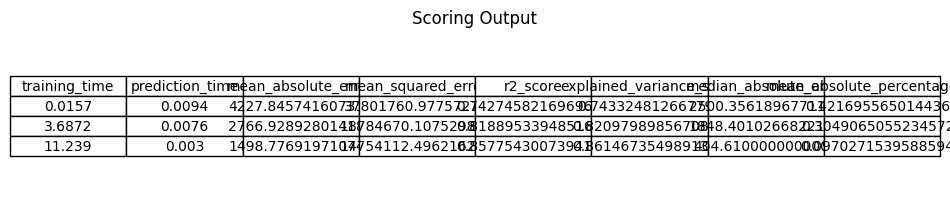

In [257]:
dataframe_to_png(
    df=df_resultados,
    output_path="reports/scoring_results.png",
    title="Scoring Output"
)

In [231]:
def validation_test(val_data, model, features, objetive_feature):
    x_val = val_data[features]
    y_val = val_data[objetive_feature]

    pred = model.predict(x_val)

    df_results = pd.DataFrame({
        "Actual": y_val,
        "Predicted": pred
    })

    return df_results

In [232]:
resultados = {}


for model in modelos:
    print(f"Validating model: {model}")
    resultados[model] = validation_test(datos_val, modelos[model], features, objetive_feature)

Validating model: LinearRegression
Validating model: PolynomialRegression
Validating model: BoostingRegression
Validating model: TreeRegression


In [233]:
resultados["BoostingRegression"]

,Actual,Predicted
764,9095.06825,10458.013296
887,5272.17580,5868.237333
890,29330.98315,27930.037321
1293,9301.89355,9856.327037
259,33750.29180,34218.099890
...,...,...
358,1837.28190,4075.198454
551,3972.92470,4591.331513
778,5934.37980,7844.541832
1127,5836.52040,7871.011392


In [234]:
resultados["TreeRegression"]

,Actual,Predicted
764,9095.06825,8606.217400
887,5272.17580,5266.365600
890,29330.98315,28950.469200
1293,9301.89355,8944.115100
259,33750.29180,34439.855900
...,...,...
358,1837.28190,1824.285400
551,3972.92470,3994.177800
778,5934.37980,6184.299400
1127,5836.52040,6184.299400


In [235]:
resultados["LinearRegression"]

,Actual,Predicted
764,9095.06825,9326.582483
887,5272.17580,7281.152483
890,29330.98315,36748.190150
1293,9301.89355,9548.708581
259,33750.29180,26709.810704
...,...,...
358,1837.28190,7178.424890
551,3972.92470,5406.662149
778,5934.37980,9087.184349
1127,5836.52040,9371.547137


In [236]:
resultados["PolynomialRegression"]

,Actual,Predicted
764,9095.06825,10998.179596
887,5272.17580,6041.728581
890,29330.98315,33917.089467
1293,9301.89355,11221.528590
259,33750.29180,28484.511446
...,...,...
358,1837.28190,2291.424640
551,3972.92470,5497.677227
778,5934.37980,7952.362340
1127,5836.52040,7628.337188
